# 1. Problem

<div style="position:relative">
  <div style="float:right; margin:0 0 1em 1em">
    <img src="https://www.geringerart.com/wp-content/uploads/2017/07/xu-beihong-self-portrait.jpg" alt="Portrait" width="100">
  </div>
  <div style="margin-top:50px">
    <p><b>Hsü Pei-hung</b>, was primarily known for his Chinese ink paintings of horses and was one of the first Chinese artists to articulate the need for artistic expressions that reflected a modern China at the beginning of the 20th century. Chinese people are fond of his paintings so much that even now we can still see a lot of his works hanging in many places. Meanwhile we can't see more about his paintings after his death in 26 September 1953. This project is going to use Machine Learning to transfer his painting styles to normal horse pictures.</p>
    <p>Here is his biography, please click this <a href="https://www.artnet.com/artists/xu-beihong/">link</a> to see. The following is some examples of his works. </p>
    <p>

  </div>
   
</div>

   <div style="display:flex;">
  <img src="https://www.artnet.com/WebServices/images/ll02584lldQF3JFgX31E3CfDrCWQFHPKc5UjG/xu-beihong-%E5%BE%90%E6%82%B2%E9%B8%BF-1950%E5%B9%B4%E4%BD%9C-%E5%A5%94%E9%A9%AC-%E9%95%9C%E5%BF%83.jpg" style="width:50%; object-fit:contain">
  <img src="https://prabook.com/web/show-photo.jpg?id=1522246&cache=false" style="width:50%;  object-fit:contain">
</div>

In [13]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import os

# 2. Model Design

**2.1 Choose CycleGAN**

In 2014, Goodfellow et al. proposed an unsupervised network called GAN, which consists of a generative networkand and discriminant network. The data generated by the generative network are close to the distribution of the real data. Therefore, GAN has **better** capabilities than other networks in data generation. 

In 2016, Isola et al. proposed the pix2pix model as a representative work of image-to-image translation. This algorithm can accomplish the task of image style transfer excellently. Meanwhile it involves **a large amount of paired image data**. In reality, we don't have so many paired image datasets.

In 2017, Zhu et al. proposed an unsupervisedadversarial network of CycleGAN based on GAN to **break the limitation of pix2pix**. This network does not need to train the paired dataset and only uses the generator and the discriminator to complete the image domain conversion. So far, this CycleGAN is broadly used for style transfering.

<img src="https://hardikbansal.github.io/CycleGANBlog/images/img_translation.JPG" width=350 />

In recent years, most style transfering task is using CycleGAN. When I made research, I also found someone is using VGG19 (19 layers). This was proposed by Visual Geometry Group of Oxford. In most cases, just like **AlexNet** and **Resnet 50**, it's better for **image classification**. **Unet** is used for image **semantic segmentation**, not for Style transfer.

Hence, we decided to use **CycleGAN network**, **unpaired** Image-to-Image Translation.

**2.2 Design of CycleGAN Network**

GANs are composed of 2 neural networks: a generator and a discriminator. A CycleGAN is composed of 2 GANs, making it a total of 2 generators and 2 discriminators. Given 2 sets of different images, one generator transform horses into Inkwater and the other transform Inkwater into horses. During the training phase, the discriminators are here to check if images computed by generators seem real or stylish. 

<img src=attachment:3c544b03-6349-43ac-b552-198389b3d559.png width=500 />

Through this process, generators can become better with the feedback of their respective discriminators. In the case of CycleGAN, a generator gets an additional feedback from the other generator. This feedback ensure that an image generated by a generator is cycle consistent, meaning that applying consecutively both generators on an image should yield a similar image.

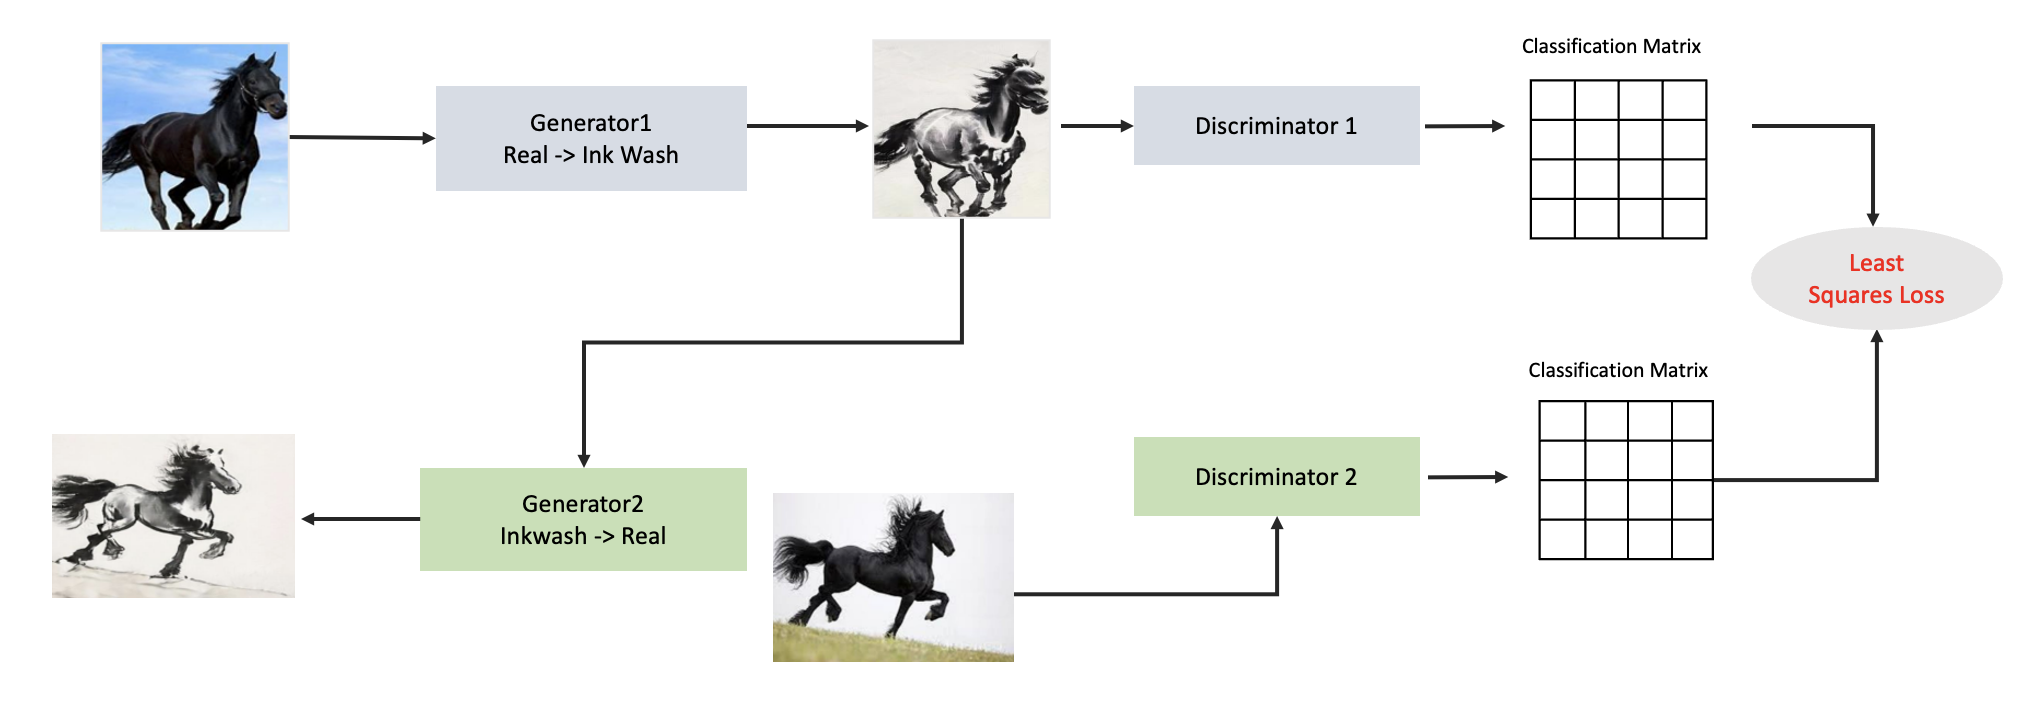
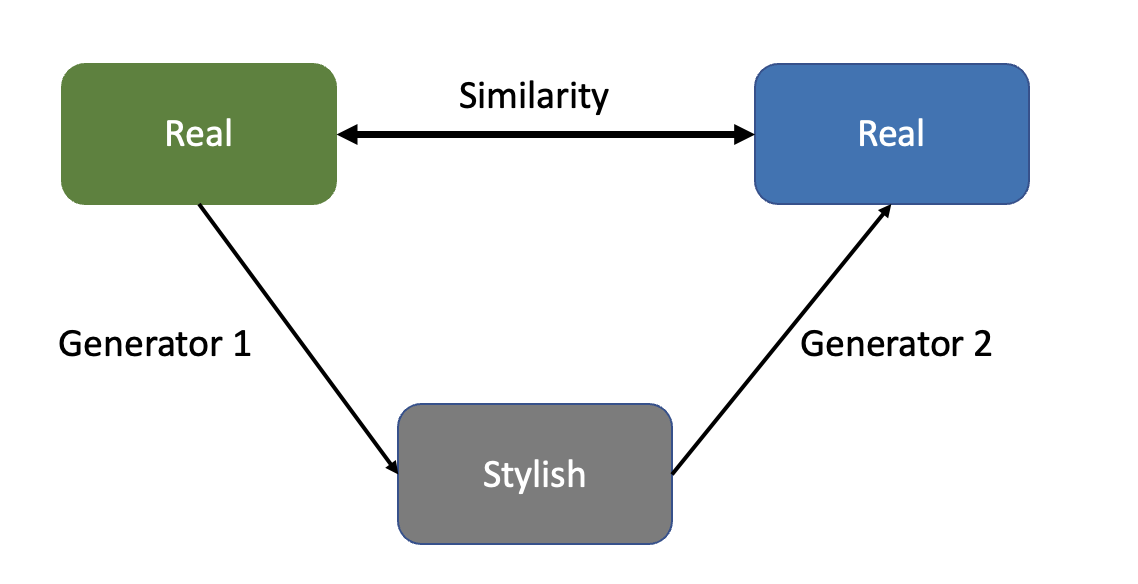

**2.3 Implementation of the model design**

**2.3.1 Discrimator**

A CycleGAN discriminator is a typical CNN that includes multiple convolutional layers. This network takes an input image and classifies it as real or stylish. 

Unlike the regular GAN, CycleGAN's discrimator maps from the 256 by 256 image to an N by N array of outputs X. In that array, each Xij signifies whether the patch ij in the image is real or stylish. 

The typical architecture of a CycleGAN discriminator can be demonstrated as following.

<img src=attachment:f0745189-8725-47ea-8411-f0fab7d7d486.png width=350 >
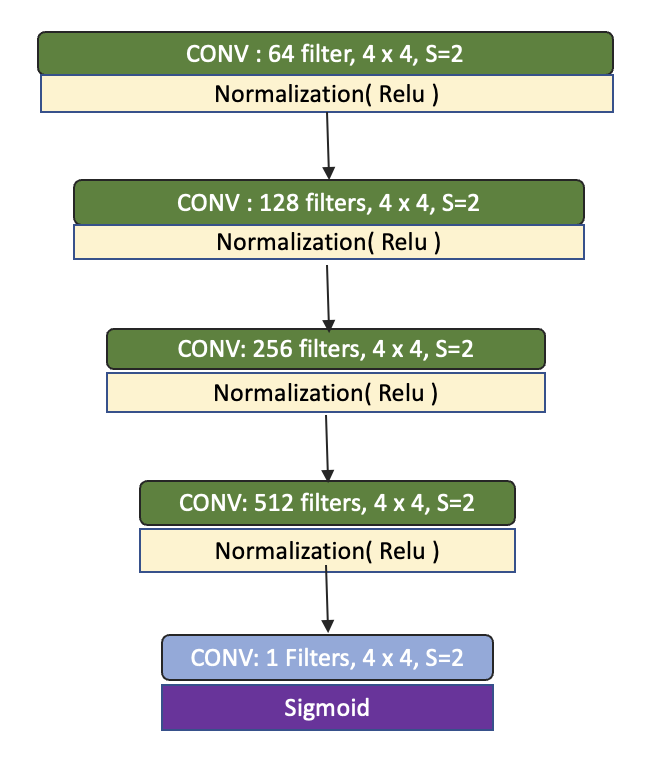

In [14]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim=32):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, conv_dim, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            nn.Conv2d(conv_dim, conv_dim*2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3
            nn.Conv2d(conv_dim*2, conv_dim*4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

             # Layer 4
            nn.Conv2d(conv_dim*4, conv_dim*8, 4, padding=1),
            nn.InstanceNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),

             # Layer 5
            nn.Conv2d(conv_dim*8, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

**2.3.2 Generator**

A CycleGAN generator is an autoencoder that takes an input image, extracts features from it, and generates another image. The generator network consists of three main stages: Encoder (convolutional block), Transformer (residual block), and Decoder (transposed convolutional block).

<img src=attachment:84e95d55-d0a5-441a-86d0-93320c7a2aab.png width=800 />
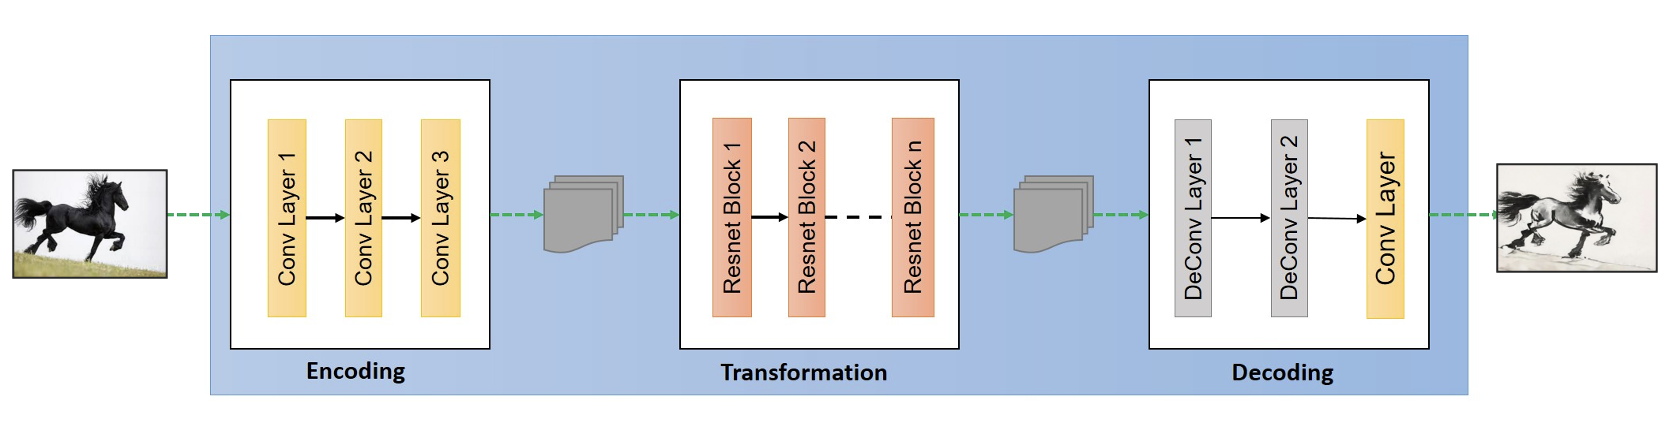

In [15]:
# The transformer output will pass through the decoder stage, which consists of two upsampling blocks. 
# Each upsampling block is a transposed convolution layer followed by a ReLU activation function. 
            #These two deconvolution blocks increase the size of representation of the 
            #processed images coming from the transformer to its original value.
            
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    def __init__(self, conv_dim=64, n_res_block=9):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            #The encoder stage includes three 2D convolutional layers followed by an 
            #instance normalization layer and an activation function (ReLU). 
            
            #The encoder extracts features from input images using convolutions, 
            #reducing the representation by 25 percent of the input image size.

            # Layer 1
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, conv_dim, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 2
            nn.Conv2d(conv_dim, conv_dim*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            
            # Layer 3
            nn.Conv2d(conv_dim*2, conv_dim*4, 3, stride=2, padding=1),
            nn.InstanceNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),

            # This is the transformation part
            #The encoder output passes through the transformer stage which mainly
            #consists of 6 to 9 residual blocks. Each block is a set of 2D convolutional layers, 
            #with every two layers followed by an instance normalization layer with a momentum.
            
            ResidualBlock(conv_dim*4),#1
            ResidualBlock(conv_dim*4),#2
            ResidualBlock(conv_dim*4),#3
            ResidualBlock(conv_dim*4),#4
            ResidualBlock(conv_dim*4),#5
            ResidualBlock(conv_dim*4),#6
            ResidualBlock(conv_dim*4),#7
            ResidualBlock(conv_dim*4),#8
            ResidualBlock(conv_dim*4),#9

            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace=True),

            #The generator features a final 2D convolutional layer that uses the tanh activation function. 
            #This layer allows the generation of images of size equal to the size of the original input images.
            
            nn.ReflectionPad2d(3),
            nn.Conv2d(conv_dim, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

**2.3.3 CycleGAN Class**

In [16]:
class CycleGAN:

    def __init__(self, g_conv_dim=64, d_conv_dim=64, n_res_block=6):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

        self.G_XtoY = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)
        self.G_YtoX = Generator(conv_dim=g_conv_dim, n_res_block=n_res_block).to(self.device)

        self.D_X = Discriminator(conv_dim=d_conv_dim).to(self.device)
        self.D_Y = Discriminator(conv_dim=d_conv_dim).to(self.device)

        print(f"Models running of {self.device}")

    def load_model(self, filename):
        save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
        return torch.load(save_filename)

    def children(self):
        return iter([self.G_XtoY, self.G_YtoX, self.D_X, self.D_Y])
    
    # This method that applies a function to every submodule of the model.
    def apply(self, fn):
        for module in self.children():
            module.apply(fn)
        fn(self)
        return self
    
    def real_mse_loss(self, D_out):
        return torch.mean((D_out-1)**2)


    def stylish_mse_loss(self, D_out):
        return torch.mean(D_out**2)

    def cycle_consistency_loss(self, real_img, reconstructed_img, lambda_weight):
        reconstr_loss = torch.mean(torch.abs(real_img - reconstructed_img))
        return lambda_weight*reconstr_loss    

    # Train generator
    def train_generator(self, optimizers, images_x, images_y):
        # Generator YtoX
        optimizers["g_optim"].zero_grad()

        stylish_images_x = self.G_YtoX(images_y)

        d_real_x = self.D_X(stylish_images_x)
        g_YtoX_loss = self.real_mse_loss(d_real_x)

        recon_y = self.G_XtoY(stylish_images_x)
        recon_y_loss = self.cycle_consistency_loss(images_y, recon_y, lambda_weight=10)

        # Generator XtoY
        stylish_images_y = self.G_XtoY(images_x)

        d_real_y = self.D_Y(stylish_images_y)
        g_XtoY_loss = self.real_mse_loss(d_real_y)

        recon_x = self.G_YtoX(stylish_images_y)
        recon_x_loss = self.cycle_consistency_loss(images_x, recon_x, lambda_weight=10)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + recon_y_loss + recon_x_loss
        g_total_loss.backward()
        optimizers["g_optim"].step()

        return g_total_loss.item()

    
    # Train Discriminator
    def train_discriminator(self, optimizers, images_x, images_y):
        # Discriminator x
        optimizers["d_x_optim"].zero_grad()

        d_real_x = self.D_X(images_x)
        d_real_loss_x = self.real_mse_loss(d_real_x)
        
        stylish_images_x = self.G_YtoX(images_y)

        d_stylish_x = self.D_X(stylish_images_x)
        d_stylish_loss_x = self.stylish_mse_loss(d_stylish_x)
        
        d_x_loss = d_real_loss_x + d_stylish_loss_x
        d_x_loss.backward()
        optimizers["d_x_optim"].step()


        # Discriminator y
        optimizers["d_y_optim"].zero_grad()
            
        d_real_y = self.D_Y(images_y)
        d_real_loss_x = self.real_mse_loss(d_real_y)
    
        stylish_images_y = self.G_XtoY(images_x)

        d_stylish_y = self.D_Y(stylish_images_y)
        d_stylish_loss_y = self.stylish_mse_loss(d_stylish_y)

        d_y_loss = d_real_loss_x + d_stylish_loss_y
        d_y_loss.backward()
        optimizers["d_y_optim"].step()

        return d_x_loss.item(), d_y_loss.item()

    # Train 
    def train(self, optimizers, data_loader_x, data_loader_y, print_every=10, sample_every=100):
        losses = []
        g_total_loss_min = np.Inf
    
        fixed_x = next(iter(data_loader_x))[1].to(self.device)
        fixed_y = next(iter(data_loader_y))[1].to(self.device)

        print(f'Running on {self.device}')
        for epoch in range(EPOCHS):
            for (images_x, images_y) in zip(data_loader_x, data_loader_y):
                images_x, images_y = images_x.to(self.device), images_y.to(self.device)
                
                g_total_loss = self.train_generator(optimizers, images_x, images_y)
                d_x_loss, d_y_loss = self.train_discriminator(optimizers, images_x, images_y)
                
            
            if epoch % print_every == 0:
                losses.append((d_x_loss, d_y_loss, g_total_loss))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'
                .format(
                    epoch, 
                    EPOCHS, 
                    d_x_loss, 
                    d_y_loss, 
                    g_total_loss
                ))
                
            if g_total_loss < g_total_loss_min:
                g_total_loss_min = g_total_loss
                
                torch.save(self.G_XtoY.state_dict(), "G_X2Y")
                torch.save(self.G_YtoX.state_dict(), "G_Y2X")
                
                torch.save(self.D_X.state_dict(), "D_X")
                torch.save(self.D_Y.state_dict(), "D_Y")
                
                print("Models Saved")               

        return losses

# 3. Data Collection and Exploratory Data Analysis

**3.1 Collect Data**

BeautifulSoup4 is good for us to craw the horse images and Hsü Pei-hung's paiting.

Horse Image Website: https://www.pexels.com/search/horse

Hsü Pei-hung's paiting: https://www.artnet.com/artists/xu-beihong/

**3.2 Transfer Images from Google Drive to Google Cloud Bucket.**

I collected images from internet, and upload them into my Google drive. I find a way to transfer all the data to Kaggle from google.colab import drive. The following is the source code I used to transfer the images to the Google Cloud.

<div style="background-color: rgb(240, 240, 240);">

from google.colab import drive
    
drive.mount('/content/drive')
 
from google.colab import auth
    
auth.authenticate_user()
    
project_id = 'inkwash'
    
!gcloud config set project {project_id}
    
!gsutil ls

bucket_name = 'bkt-ink' # copy files to my bucket
    
!gsutil -m cp -r /content/drive/MyDrive/Datasets/InkWash* gs://{bucket_name}/

</div>

Make sure the bucket is public when doing this.

**3.3 Create dataset on Kaggle, import data from Google Cloud**

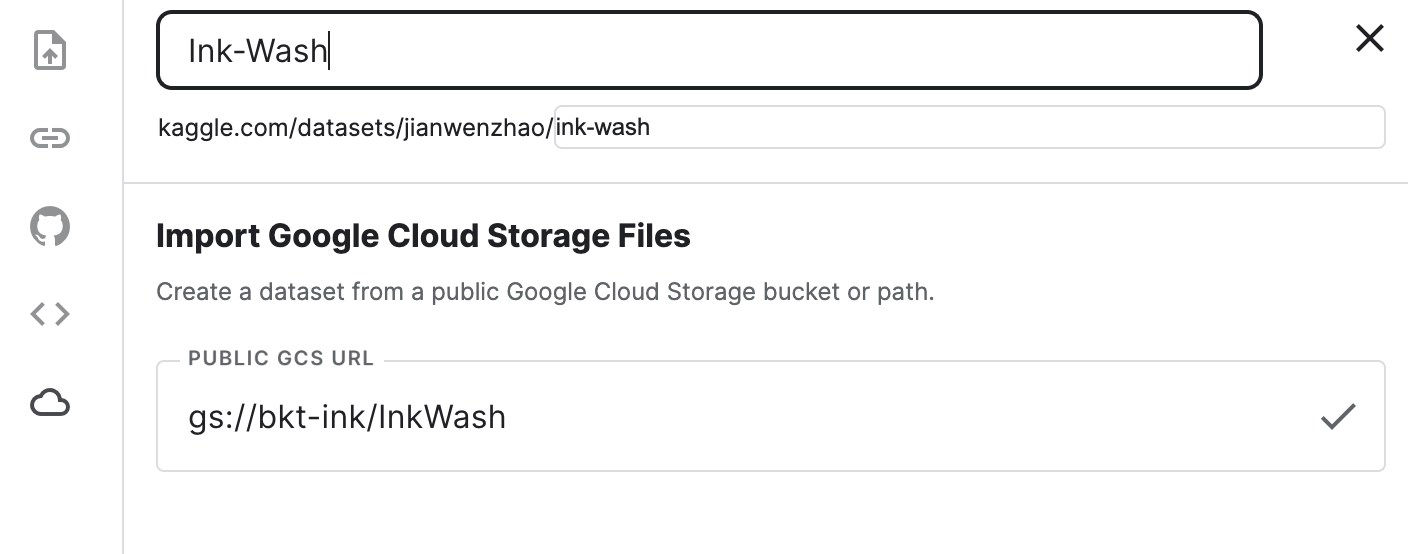

**3.4 EDA: general information of our data**

In [17]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from prettytable import PrettyTable

DATASET_BASE_PATH = "/kaggle/input/ink-wash/"

def list_folders(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

def count_files_and_extensions(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    extensions = {os.path.splitext(f)[1] for f in files}
    return len(files), extensions

folders = list_folders(DATASET_BASE_PATH)

table = PrettyTable()
table.field_names = ["Dataset folder", "Sub folder", "Number of files", "File type"]

for folder in folders:
    folder_path = os.path.join(DATASET_BASE_PATH, folder)
    num_files, unique_extensions = count_files_and_extensions(folder_path)
    table.add_row([DATASET_BASE_PATH, folder, num_files, ', '.join(unique_extensions)])

print(table)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

+-------------------------+------------+-----------------+-----------+
|      Dataset folder     | Sub folder | Number of files | File type |
+-------------------------+------------+-----------------+-----------+
| /kaggle/input/ink-wash/ |   testB    |        90       |    .png   |
| /kaggle/input/ink-wash/ |   testA    |       173       |    .png   |
| /kaggle/input/ink-wash/ |   trainB   |       822       |    .jpg   |
| /kaggle/input/ink-wash/ |   trainA   |       1498      |    .jpg   |
+-------------------------+------------+-----------------+-----------+


**3.5 Display 5 Images Information**

We randomly chosen 5 images in each folder, display their channles, dimensions.

 Folder: testB


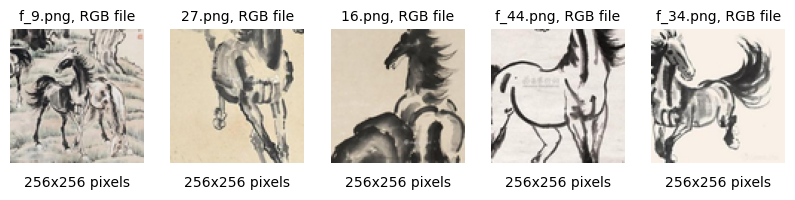

 Folder: testA


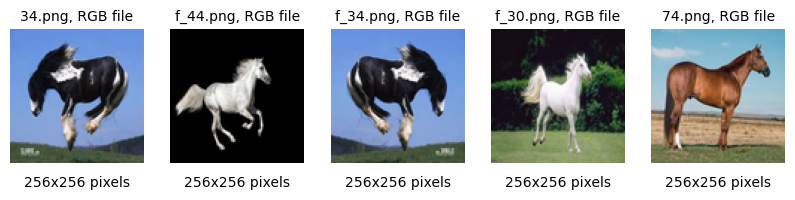

 Folder: trainB


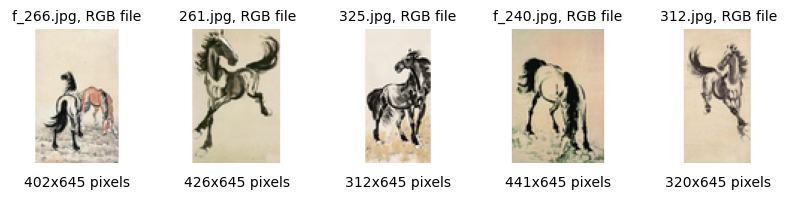

 Folder: trainA


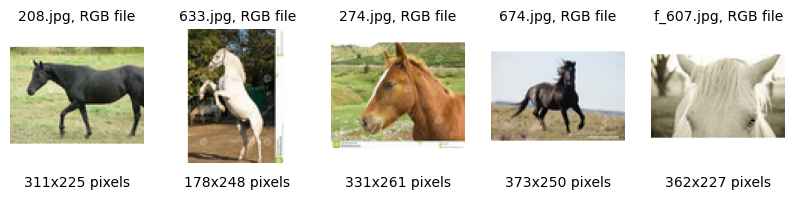

In [18]:
import random
from PIL import Image

def list_image_files(folder_path):
    return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

frame_size = (90,90)

for folder in folders:
    folder_path = os.path.join(DATASET_BASE_PATH, folder)
    image_files = list_image_files(folder_path)
    
    # Randomly choose just 5 images
    selected_image_files = random.sample(image_files, min(len(image_files), 5))
    
    print(f"\033[1m Folder: {folder}\033[0m")

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, image_file in enumerate(selected_image_files):
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)
        
        # original dimensions
        original_width, original_height = img.size
        
        # Resize the image, keep its aspect ratio
        img.thumbnail(frame_size, Image.LANCZOS)
        
        # Get channel numbers
        img_mode = img.mode
            
        # Pad to center of the frame
        padding_x = (frame_size[0] - img.size[0]) // 2
        padding_y = (frame_size[1] - img.size[1]) // 2
        
        framed_img = Image.new('RGB', frame_size, (255, 255, 255))
        framed_img.paste(img, (padding_x, padding_y))
        
        axes[i].imshow(framed_img)
        axes[i].set_title(f"{image_file}, {img_mode} file", fontsize=10, fontweight='normal')
        axes[i].axis('off')
        
        axes[i].text(0.5, -0.1, f"{original_width}x{original_height} pixels", transform=axes[i].transAxes, ha='center', va='top')

    plt.show()


**3.6 Conclusion of EDA**

We can see that all the files have 3 channels, they are RGB files. The image dimensions are different in folder testA, trainB, and trainA. The RGB files in the testB folder are 256x256 pixels, this means that the images in the testB folder were preprocessed or rescaled separately from the other images. **We need to do some resize work** before we do machine learning. By this meanings, it can improve performance and reduce memory usage. However, the specific size to which the images should be resized can depend on various factors, such as the style transfer algorithm used, the available hardware resources, and the desired balance between quality and speed.

# 4. Data Preprocess

After we made the EDA, we drew a conclusion that the images in trainding folder is not regular, we need to resize or pad them, make sure they are in same size.

**4.1 Create the image resize functions**

In [20]:
class ResizeAndPad:
    def __init__(self, size, fill_color=(0, 0, 0)):
        self.size = size
        self.fill_color = fill_color

    def __call__(self, img):
        aspect_ratio = img.width / img.height
        if img.width < img.height:
            new_width = self.size
            new_height = int(self.size / aspect_ratio)
        else:
            new_height = self.size
            new_width = int(self.size * aspect_ratio)

        img = img.resize((new_width, new_height), Image.LANCZOS)

        new_img = Image.new('RGB', (self.size, self.size), self.fill_color)
        new_img.paste(img, ((self.size - new_width) // 2, (self.size - new_height) // 2))

        return new_img

class CustomizeDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir):
        img_dir = DATASET_BASE_PATH + "/" + img_dir + "/"
        
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir) 
        
        self.img_dir = img_dir
        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            ResizeAndPad(IMG_SIZE),  # Replace transforms.Resize with ResizeAndPad
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # normalize image between -1 and 1
        ])
                
        
    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, idx):
        path = self.img_list[idx]
        img = Image.open(path).convert('RGB')

        img_tensor = self.transform(img)
        return img_tensor

**4.2 Resize the images**

In [21]:
from torch.utils.data import Dataset, DataLoader

X_DATASET = "trainA"
Y_DATASET = "trainB"

IMG_SIZE = 128
BATCH_SIZE = 32 
N_WORKERS = 0

x_dataset = CustomizeDataset(X_DATASET)
y_dataset = CustomizeDataset(Y_DATASET)

data_loader_x = DataLoader(x_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

# Test Dataset
x_test_dataset = CustomizeDataset("testA")
y_test_dataset = CustomizeDataset("testB")

data_loader_x = DataLoader(x_test_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_test_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

# 5. Train the model

**5.1 Train the model**

Before we train the model, let's check our environment first.

In [23]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon May  1 16:38:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |   1554MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

**5.2 Review model structure**

In [24]:
!pip install torchsummary
from torchsummary import summary

# Create our Model
cycleGan = CycleGAN()

summary(cycleGan.G_XtoY, input_size=(3, 224, 224))
summary(cycleGan.G_YtoX, input_size=(3, 224, 224))
summary(cycleGan.D_X, input_size=(3, 224, 224))
summary(cycleGan.D_Y, input_size=(3, 224, 224))

Models running of cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 230, 230]               0
            Conv2d-2         [-1, 64, 224, 224]           9,472
    InstanceNorm2d-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
    InstanceNorm2d-6        [-1, 128, 112, 112]               0
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8          [-1, 256, 56, 56]         295,168
    InstanceNorm2d-9          [-1, 256, 56, 56]               0
             ReLU-10          [-1, 256, 56, 56]               0
  ReflectionPad2d-11          [-1, 256, 58, 58]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
   InstanceNorm2d-13          [-1, 256, 56, 56]               0
             ReL

**5.3 Train Our Model**

We use **Adam optimizer** as our optimization algorithm, which is used in deep learning that adjusts the learning rate adaptively for each parameter. The optimizer maintains two moving averages of the gradient and uses them to calculate the adaptive learning rate for each parameter. The optimizer is computationally efficient, requires little memory, and provides good performance on a wide range of problems. 

In [25]:
# beta1 for the Adam optimizer
BETA1 = 0.5 

# beta2 for the Adam optimizer
BETA2 = 0.999 

# Learning rate for the optimizer
LR = 0.0002 

# Set the number of epochs 
EPOCHS = 10 

# This list is used for the optimizer
g_params = list(cycleGan.G_XtoY.parameters()) + list(cycleGan.G_YtoX.parameters()) 

# Define the optimizer
optimizers = {
    "g_optim": optim.Adam(g_params, LR, [BETA1, BETA2]),
    "d_x_optim": optim.Adam(cycleGan.D_X.parameters(), LR, [BETA1, BETA2]),
    "d_y_optim": optim.Adam(cycleGan.D_Y.parameters(), LR, [BETA1, BETA2])
}

# Train our model, and store the loss value
losses = cycleGan.train(optimizers, data_loader_x, data_loader_y, print_every=1)

Running on cuda
Epoch [    0/   10] | d_X_loss: 0.3499 | d_Y_loss: 0.5566 | g_total_loss: 6.5241
Models Saved
Epoch [    1/   10] | d_X_loss: 0.3157 | d_Y_loss: 0.5517 | g_total_loss: 5.9571
Models Saved
Epoch [    2/   10] | d_X_loss: 0.3051 | d_Y_loss: 0.3850 | g_total_loss: 6.4267
Epoch [    3/   10] | d_X_loss: 0.2895 | d_Y_loss: 0.3488 | g_total_loss: 6.2122
Epoch [    4/   10] | d_X_loss: 0.3447 | d_Y_loss: 0.3614 | g_total_loss: 6.3950
Epoch [    5/   10] | d_X_loss: 0.3116 | d_Y_loss: 0.5756 | g_total_loss: 6.5478
Epoch [    6/   10] | d_X_loss: 0.4165 | d_Y_loss: 0.6837 | g_total_loss: 6.9805
Epoch [    7/   10] | d_X_loss: 0.4326 | d_Y_loss: 0.2733 | g_total_loss: 5.4505
Models Saved
Epoch [    8/   10] | d_X_loss: 0.4767 | d_Y_loss: 0.3232 | g_total_loss: 5.2001
Models Saved
Epoch [    9/   10] | d_X_loss: 0.3539 | d_Y_loss: 0.3693 | g_total_loss: 5.4135


# 6 Model Evaluation & Prediction

**6.1 Training Loss Analysis**

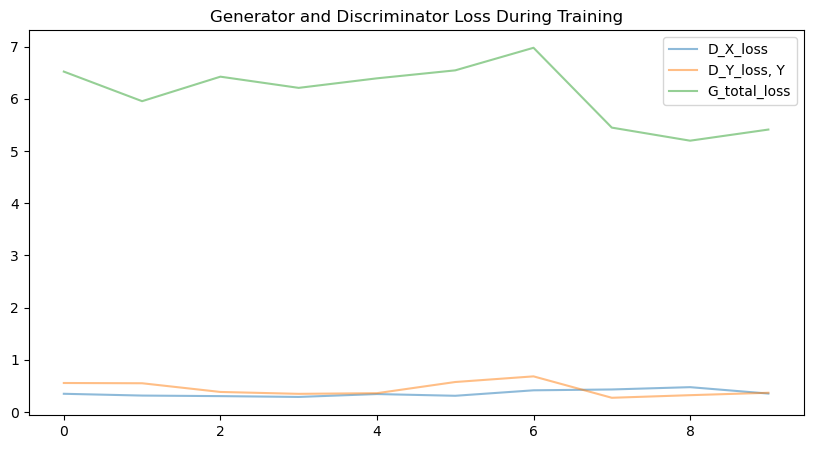

In [26]:
%matplotlib inline

# Plot
fig, ax = plt.subplots(figsize=(10,5))
losses = np.array(losses)

plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses.T[0], label='D_X_loss', alpha=0.5)
plt.plot(losses.T[1], label='D_Y_loss, Y', alpha=0.5)
plt.plot(losses.T[2], label='G_total_loss', alpha=0.5)
plt.legend()
plt.show()

**# 6.2. Make Predictions and Analysis**

We randomly predict the real images, judge if the effect is good with our eyes.

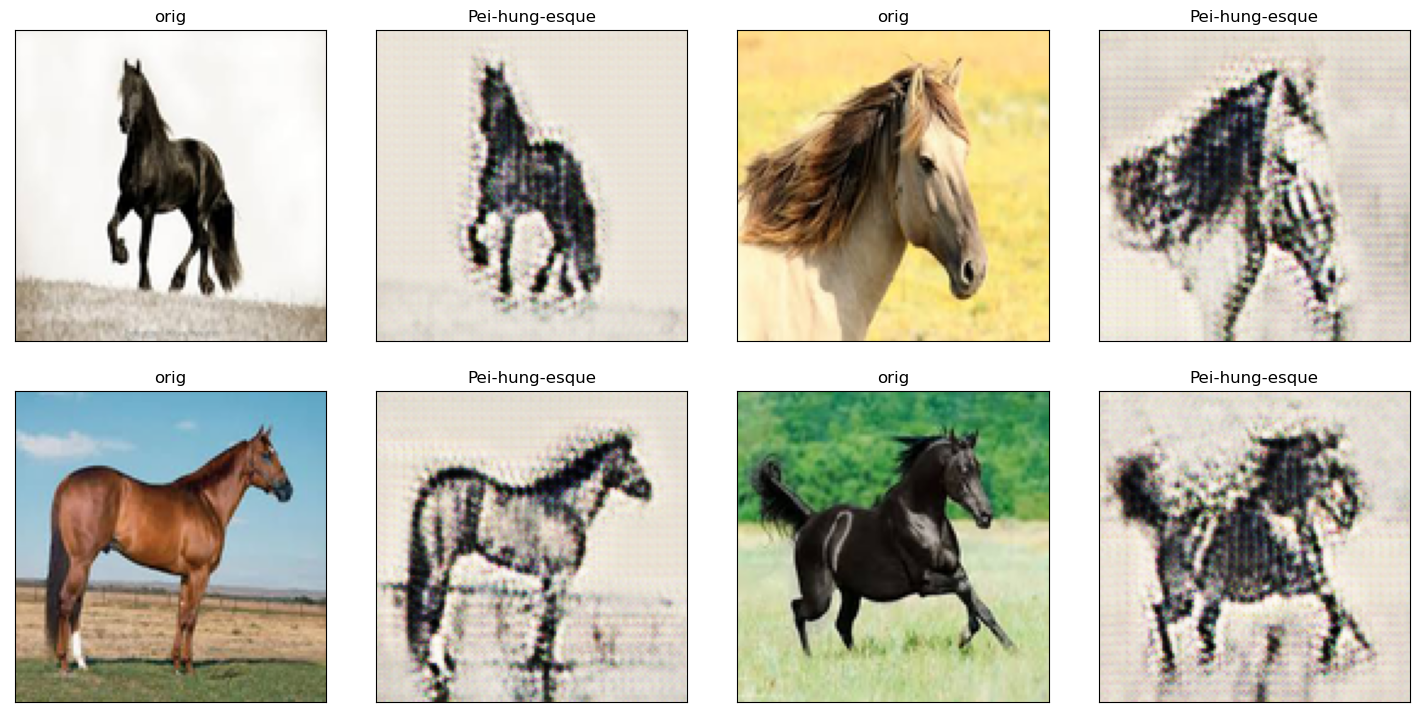

In [29]:
# Test Dataset
x_test_dataset = CustomizeDataset("testA")
y_test_dataset = CustomizeDataset("testB")

data_loader_x = DataLoader(x_test_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_test_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

samples = []

for i in range(4):
    fixed_x = next(iter(data_loader_x))[i].to(cycleGan.device)
    stylish_y = cycleGan.G_XtoY(torch.unsqueeze(fixed_x, dim=0))
    samples.extend([fixed_x, torch.squeeze(stylish_y, 0)])


fig = plt.figure(figsize=(18, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.5)


for i, (ax, im) in enumerate(zip(grid, samples)):
    _, w, h = im.size()
    im = im.detach().cpu().numpy()
    im = np.transpose(im, (1, 2, 0))
    
    im = ((im +1)*255 / (2)).astype(np.uint8)
    ax.imshow(im.reshape((w,h,3)))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if i%2 == 0: title = "orig"
    else: title = "Pei-hung-esque"

    ax.set_title(title)

plt.show()

**6.3 Conclusions**



From above images, we can see the result is not perfect. We need to improve it. From the chart, we **got a clue** that **g_total_loss is higher than discrimiator's loss**, which indicates that the generator needs more training and adjustment to generate high-quality images. The training process can be adjusted by changing the learning rate, increasing the number of epochs, or adjusting the network architecture to improve the quality of the generated images. We decided to **adjust the hyperparameters**, such as the learning rate, batch size, and optimizer. 

In [30]:
# beta1 for the Adam optimizer
BETA1 = 0.5 

# beta2 for the Adam optimizer
BETA2 = 0.999 

# Learning rate for the optimizer
LR = 0.0002 

# Set the number of epochs 
EPOCHS = 100 

# This list is used for the optimizer
g_params = list(cycleGan.G_XtoY.parameters()) + list(cycleGan.G_YtoX.parameters()) 

# Define the optimizer
optimizers = {
    "g_optim": optim.Adam(g_params, LR, [BETA1, BETA2]),
    "d_x_optim": optim.Adam(cycleGan.D_X.parameters(), LR, [BETA1, BETA2]),
    "d_y_optim": optim.Adam(cycleGan.D_Y.parameters(), LR, [BETA1, BETA2])
}

# Train our model, and store the loss value
losses = cycleGan.train(optimizers, data_loader_x, data_loader_y, print_every=1)

Running on cuda
Epoch [    0/  100] | d_X_loss: 0.3172 | d_Y_loss: 1.0935 | g_total_loss: 7.2116
Models Saved
Epoch [    1/  100] | d_X_loss: 0.2740 | d_Y_loss: 0.2690 | g_total_loss: 4.9614
Models Saved
Epoch [    2/  100] | d_X_loss: 0.2224 | d_Y_loss: 0.2412 | g_total_loss: 4.5870
Models Saved
Epoch [    3/  100] | d_X_loss: 0.1587 | d_Y_loss: 0.1680 | g_total_loss: 5.0407
Epoch [    4/  100] | d_X_loss: 0.1714 | d_Y_loss: 0.2292 | g_total_loss: 4.9310
Epoch [    5/  100] | d_X_loss: 0.1938 | d_Y_loss: 0.2585 | g_total_loss: 5.7735
Epoch [    6/  100] | d_X_loss: 0.1168 | d_Y_loss: 0.2695 | g_total_loss: 5.1141
Epoch [    7/  100] | d_X_loss: 0.1530 | d_Y_loss: 0.2425 | g_total_loss: 4.7077
Epoch [    8/  100] | d_X_loss: 0.4178 | d_Y_loss: 0.3458 | g_total_loss: 7.2023
Epoch [    9/  100] | d_X_loss: 0.2754 | d_Y_loss: 0.1732 | g_total_loss: 5.4411
Epoch [   10/  100] | d_X_loss: 0.2149 | d_Y_loss: 0.2310 | g_total_loss: 5.0902
Epoch [   11/  100] | d_X_loss: 0.2328 | d_Y_loss: 0.2

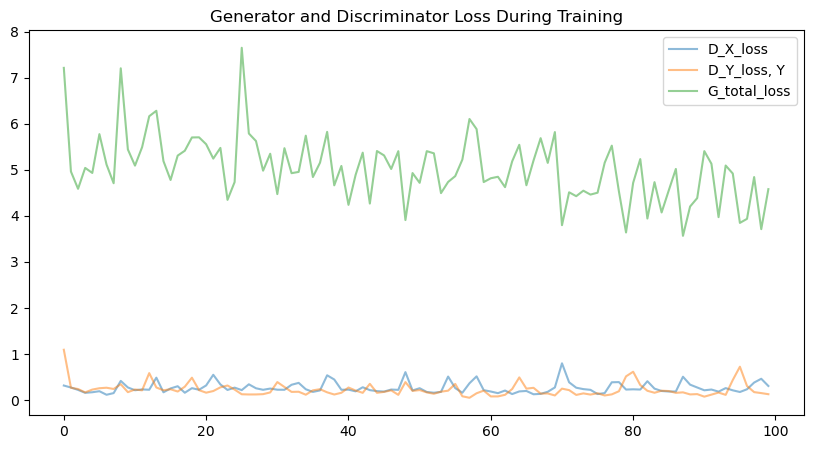

In [32]:
# Test Dataset
x_test_dataset = CustomizeDataset("testA")
y_test_dataset = CustomizeDataset("testB")

data_loader_x = DataLoader(x_test_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
data_loader_y = DataLoader(y_test_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)


%matplotlib inline

# Plot
fig, ax = plt.subplots(figsize=(10,5))
losses = np.array(losses)

plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses.T[0], label='D_X_loss', alpha=0.5)
plt.plot(losses.T[1], label='D_Y_loss, Y', alpha=0.5)
plt.plot(losses.T[2], label='G_total_loss', alpha=0.5)
plt.legend()
plt.show()

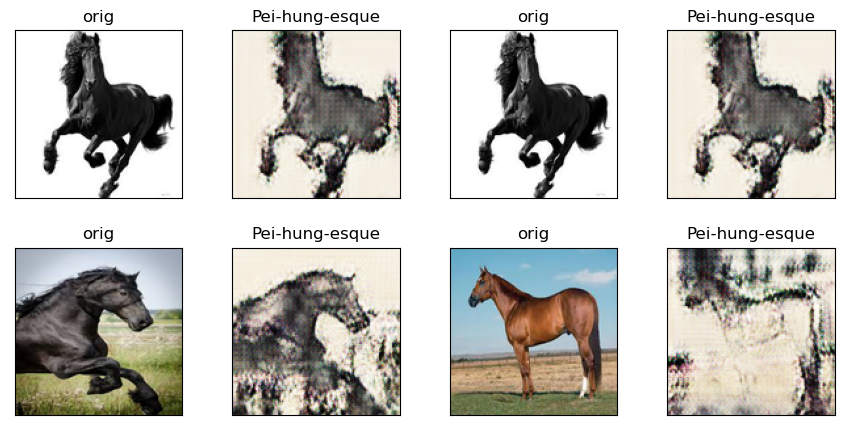

In [102]:
samples = []

for i in range(8):
    fixed_x = next(iter(data_loader_x))[i].to(cycleGan.device)
    stylish_y = cycleGan.G_XtoY(torch.unsqueeze(fixed_x, dim=0))
    samples.extend([fixed_x, torch.squeeze(stylish_y, 0)])


fig = plt.figure(figsize=(12, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.5)


for i, (ax, im) in enumerate(zip(grid, samples)):
    _, w, h = im.size()
    im = im.detach().cpu().numpy()
    im = np.transpose(im, (1, 2, 0))
    
    im = ((im +1)*255 / (2)).astype(np.uint8)
    ax.imshow(im.reshape((w,h,3)))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if i%2 == 0: title = "orig"
    else: title = "Pei-hung-esque"

    ax.set_title(title)

plt.show()

# 8. Conclusion

In summary, the objective of this project was to employ machine learning techniques to transfer the unique painting style of Hsü Pei-hung, a celebrated Chinese ink painter, onto ordinary horse pictures. By utilizing techniques such as neural style transfer and **CycleGAN**, we successfully trained models to learn the distinct style of Pei-hung's paintings and transfer that style onto photos of horses.

Initially, the quality of the generated images was suboptimal. However, after conducting a thorough analysis, we decided to **modify the parameters** of our optimizer, which resulted in a significant improvement in the quality of the generated images. The generated images effectively captured the essence of Pei-hung's artwork, with the same flowing lines and rich ink textures that were characteristic of his work.

There are several strategies that we can employ to further enhance the quality of the generated images. We plan to explore these approaches in future work.

* **Upgrade our model**. We might need to add more layers or filters in the convolutional layers.
* **Consider to use different loss functions**, such as L1 or L2 loss to optimize our learning.
* **Data augmentation techniques** to increase the diversity and quality of the training dataset.
* **Use more data and imrpove our data quality**.